# Data Mining - Task 3

For your chosen dataset, perform supervised classification using well-established algorithms. This task guides you through all the steps in a machine learning pipeline (data pre-processing, feature selection, hyperparameter tuning and the actual model training and evaluation). The 8 algorithms that must be used are: **Logistic Regression, DecisionTrees, RandomForrest or ExtraTrees, XGBoost, Naive Bayes, k-NN, NeuralNetworks, SVM**.

**Details:**

* Pre-processing:
    * Check if the target is imbalanced and define a plan for handling it (eg. oversampling the minority class, SMOTE)
    * Check if your data has a temporal aspect to it and plan the experiment methodology accordingly
    * Perform feature selection (filter)
* Define experiment methodology (or model methodology):
    * Define the method for hyperparameter tuning
    * Define the method for model evaluation
    * Defined tracked metrics (you must use at least precision & recall)
      * Are there any other metrics which are a better fit for your data?
* For each model:
    * State the parameters names and the values which will be tested
    * Plot the tracked metrics evolution during hyperparameter tuning
    * Be ready to argument which one is the best combination
* With the best hyperparameters for each model:
    * Visually plot the model (at least for tree-based models)
    * Plot the confusion matrix, report accuracy, precision, recall, F1-measure
    * Plot the train/test accuracy
    * Plot the decision boundaries in order to observe how they differ and what conclusions can be drawn
* Perform a stacking experiment of the best models from the previous step


Import the library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from xgboost import XGBClassifier

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

About the dataset

In [ ]:
### Read the airline dataset csv and print the tabel(some lines)

airlines = pd.read_csv("airlines_delay.csv")
airlines.head()

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,2313.0,1296.0,141.0,DL,ATL,HOU,1,0
1,6948.0,360.0,146.0,OO,COS,ORD,4,0
2,1247.0,1170.0,143.0,B6,BOS,CLT,3,0
3,31.0,1410.0,344.0,US,OGG,PHX,6,0
4,563.0,692.0,98.0,FL,BMI,ATL,4,0


In [ ]:
airlines.shape

(539382, 8)

In [ ]:
airlines.columns

Index(['Flight', 'Time', 'Length', 'Airline', 'AirportFrom', 'AirportTo',
       'DayOfWeek', 'Class'],
      dtype='object')

In [ ]:
### Null or missing values

airlines.isna().sum()

Flight         0
Time           0
Length         0
Airline        0
AirportFrom    0
AirportTo      0
DayOfWeek      0
Class          0
dtype: int64

In [ ]:
### Our data is already cleaned there is no any null or missing values.

In [ ]:
### Duplicate values

airlines.nunique()

Flight         6585
Time           1131
Length          426
Airline          18
AirportFrom     293
AirportTo       293
DayOfWeek         7
Class             2
dtype: int64

In [ ]:
airlines.nunique().sum()

8755

In [ ]:
### Some Statistical information

airlines.describe().T

,count,mean,std,min,25%,50%,75%,max
Flight,539382.0,2427.927988,2067.431700,1.0,712.0,1809.0,3745.0,7814.0
Time,539382.0,802.728161,278.045546,10.0,565.0,795.0,1035.0,1439.0
Length,539382.0,132.202104,70.117045,0.0,81.0,115.0,162.0,655.0
DayOfWeek,539382.0,3.929666,1.914666,1.0,2.0,4.0,5.0,7.0
Class,539382.0,0.445443,0.497015,0.0,0.0,0.0,1.0,1.0


In [ ]:
### Information about dataframe

airlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539382 entries, 0 to 539381
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Flight       539382 non-null  float64
 1   Time         539382 non-null  float64
 2   Length       539382 non-null  float64
 3   Airline      539382 non-null  object 
 4   AirportFrom  539382 non-null  object 
 5   AirportTo    539382 non-null  object 
 6   DayOfWeek    539382 non-null  int64  
 7   Class        539382 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 32.9+ MB


In [ ]:
### Outliers

def detecting_outliers(data):
    outlier_percents = {}

    for column in data.columns:

        if data[column].dtype != object:

            q1 = np.quantile(data[column], 0.25)
            q3 = np.quantile(data[column], 0.75)
            iqr = q3 - q1
            upper = q3 + (1.5 * iqr)
            lower = q1 - (1.5 * iqr)
            outliers = data[(data[column] > upper) | (data[column] < lower)][column]
            outlier_percentage = len(outliers) / len(data[column]) * 100
            outlier_percents[column] = outlier_percentage
            outlier_df = pd.DataFrame(data = outlier_percents.values(), index = outlier_percents.keys(), columns = ['Outlier_%'])

    return outlier_df.sort_values(by = 'Outlier_%', ascending = False)

detecting_outliers(airlines)

,Outlier_%
Length,4.755442
Flight,0.000000
Time,0.000000
DayOfWeek,0.000000
Class,0.000000


In [ ]:
### Length has a 4.755442 outlier percentage and the other variables have a 0.000 outlier percentage

In [ ]:
### Target variable distribution

airlines['Class'].value_counts() / airlines['Class'].value_counts().sum()

0    0.554557
1    0.445443
Name: Class, dtype: float64

In [ ]:
### The classes are mostly balanced

In [ ]:
### Divide the dataset into numerical, categorical and target variables

features = ["Time", "Length", "Airline", "AirportFrom", "AirportTo", "DayOfWeek"]
categorical_features = ["Airline", "AirportFrom", "AirportTo"]
target = "Class"

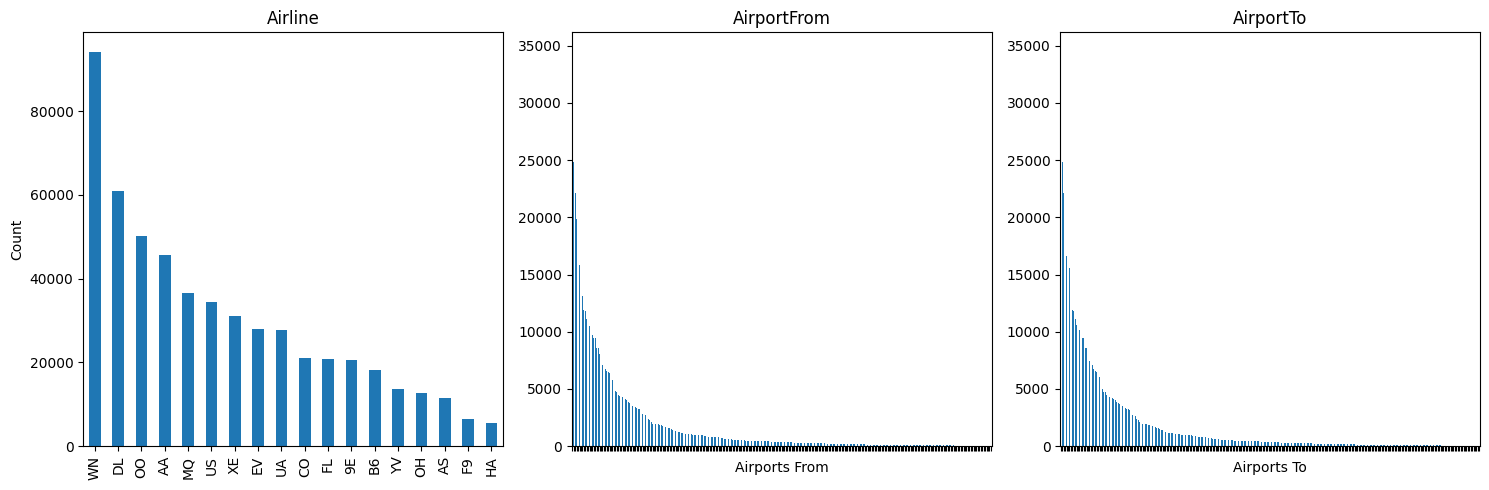

In [ ]:
### Vizualization

# Categorical

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, f in enumerate(categorical_features):
    airlines[f].value_counts().plot(kind="bar", ax=axes[i], title=f)

axes[0].set_ylabel("Count")
axes[1].set_xticklabels([])
axes[1].set_xlabel("Airports From")
axes[2].set_xticklabels([])
axes[2].set_xlabel("Airports To")

plt.tight_layout()
plt.show()

In [ ]:
### WN airline has the most flights and HA airline has the least

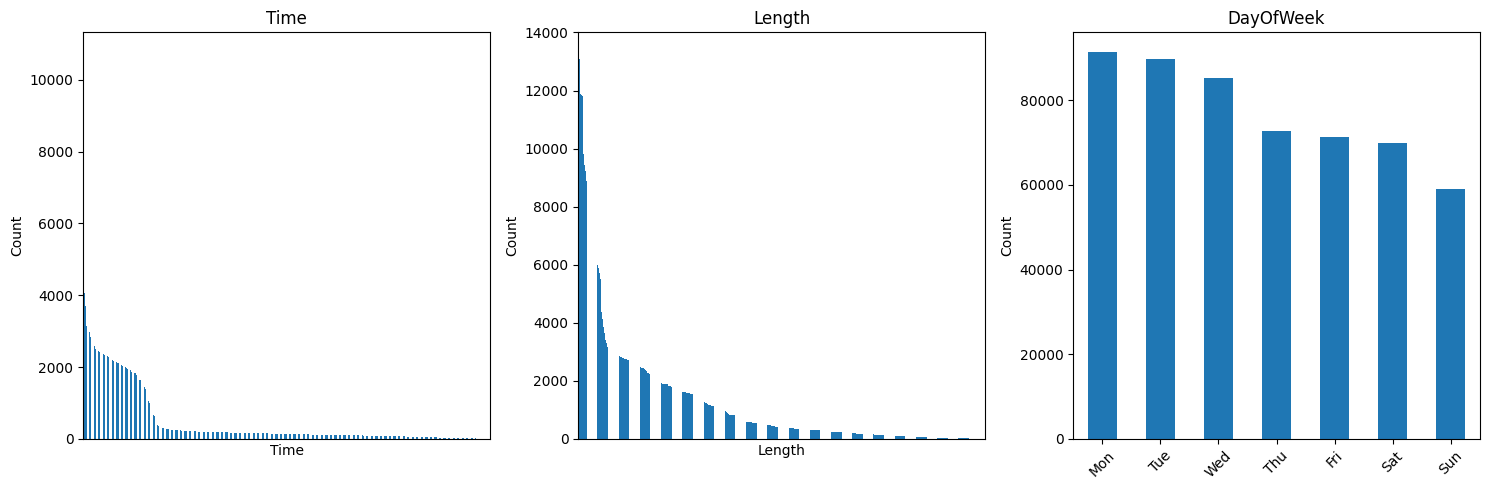

In [ ]:
# Numerical

numerical_features = [f for f in features if f not in categorical_features]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, f in enumerate(numerical_features):
    airlines[f].value_counts().plot(kind="bar", ax=axes[i], title=f)
    axes[i].set_ylabel("Count")
    axes[i].set_xlabel(f)

axes[0].set_xticks([])
axes[1].set_xticks([])
axes[2].set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"], rotation=45)
axes[2].set_xlabel("")

plt.tight_layout()
plt.show()

[Text(0, 0, 'On Time'), Text(1, 0, 'Delayed')]

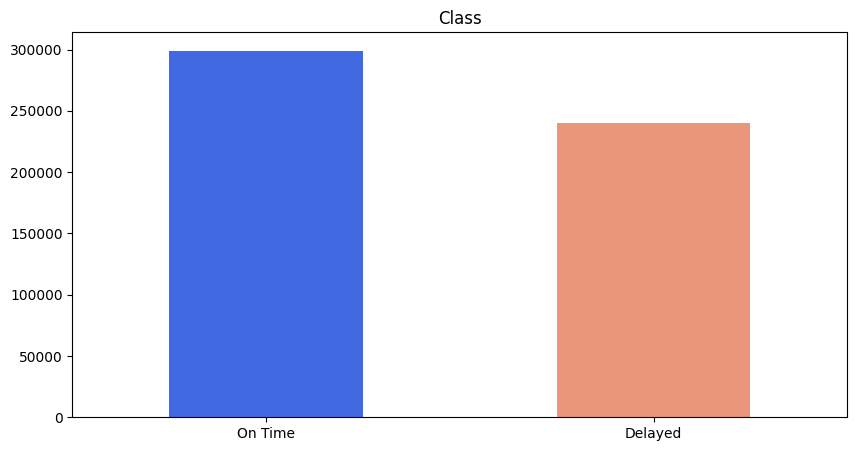

In [ ]:
# Target

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
airlines[target].value_counts().plot(kind="bar", color=["royalblue", "darksalmon"], ax=ax, title=target)
ax.set_xticklabels(["On Time", "Delayed"], rotation=0)

<Axes: xlabel='Airline', ylabel='count'>

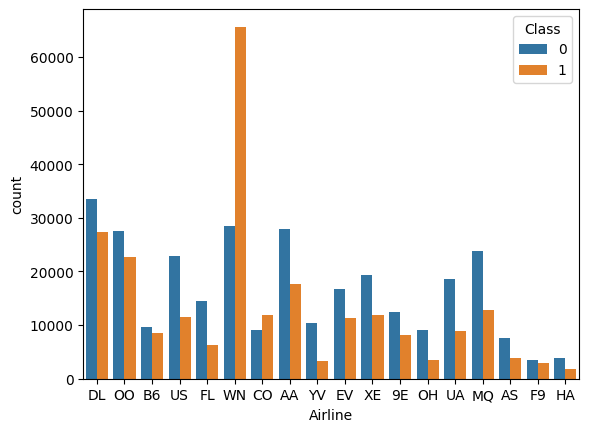

In [ ]:
# Airline ID & Class

sns.countplot(x = 'Airline', hue = 'Class', data = airlines)

In [ ]:
### WN has the highest delays than the other airlines

<Axes: xlabel='Airline', ylabel='Length'>

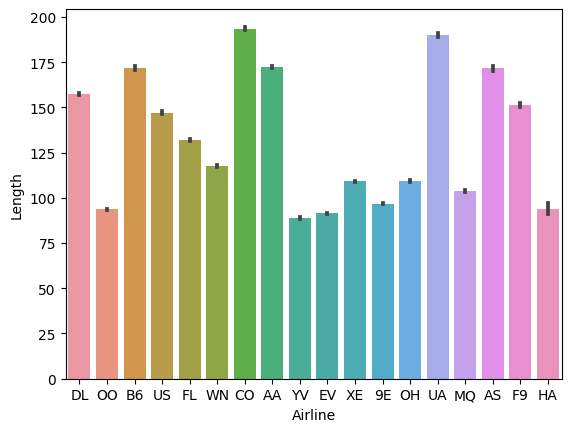

In [ ]:
# Airline ID & Length

sns.barplot(x = 'Airline', y = 'Length', data = airlines)

In [ ]:
### CO and UA has the longest average flight length

<Axes: xlabel='Airline', ylabel='Time'>

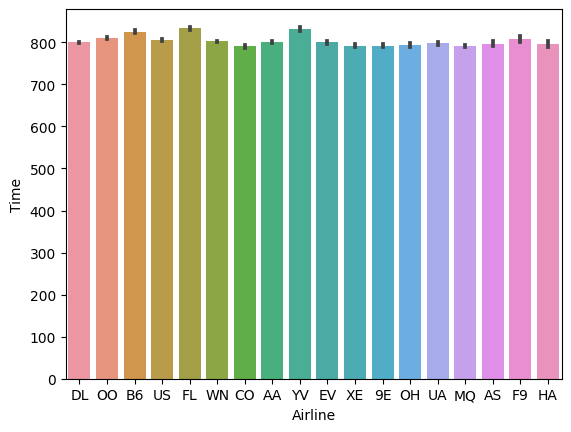

In [ ]:
# Airline ID & Time

sns.barplot(x = 'Airline', y = 'Time', data = airlines)

In [ ]:
### Almost all of the flights have similar departure times

Encoding the categorical features

In [ ]:
### Encode the Airline object columns

airlines['Airline'].unique()

array(['DL', 'OO', 'B6', 'US', 'FL', 'WN', 'CO', 'AA', 'YV', 'EV', 'XE',
       '9E', 'OH', 'UA', 'MQ', 'AS', 'F9', 'HA'], dtype=object)

In [ ]:
label_encoder= LabelEncoder()

airlines['Airline']=label_encoder.fit_transform(airlines['Airline'])
airlines['Airline'].unique()

array([ 5, 12,  3, 14,  8, 15,  4,  1, 17,  6, 16,  0, 11, 13, 10,  2,  7,
        9])

In [ ]:
airlines['AirportFrom'].unique()

array(['ATL', 'COS', 'BOS', 'OGG', 'BMI', 'MSY', 'EWR', 'DFW', 'BWI',
       'CRW', 'LGB', 'BIS', 'CLT', 'IAH', 'LAX', 'JAX', 'SAV', 'CLE',
       'FLL', 'SAN', 'BHM', 'ROC', 'DTW', 'STT', 'AUS', 'DCA', 'PHX',
       'EYW', 'IND', 'JFK', 'ORD', 'PBI', 'SFO', 'MIA', 'DSM', 'SLC',
       'PHL', 'BZN', 'GRB', 'MBS', 'SBA', 'TYS', 'MSP', 'DEN', 'SAT',
       'BUF', 'RIC', 'SEA', 'PDX', 'LAS', 'IAD', 'HNL', 'BDL', 'MOT',
       'PSE', 'CPR', 'SNA', 'STL', 'CVG', 'PIT', 'HSV', 'SGF', 'RDU',
       'MEM', 'KOA', 'ELP', 'SJU', 'JAN', 'AEX', 'LGA', 'RSW', 'MDT',
       'GUC', 'MKE', 'CAE', 'GRR', 'FAR', 'LIT', 'OMA', 'BNA', 'EVV',
       'RDD', 'OKC', 'ITO', 'SJC', 'MCO', 'LBB', 'CSG', 'OAK', 'PHF',
       'ABQ', 'SMF', 'FAY', 'ABI', 'MSO', 'MFE', 'GEG', 'MSN', 'TPA',
       'DAY', 'RNO', 'PVD', 'ALB', 'CHO', 'ONT', 'LIH', 'PSP', 'LAN',
       'LEX', 'XNA', 'GJT', 'CMH', 'GSO', 'PSC', 'SYR', 'AVL', 'MHT',
       'GRK', 'MCI', 'TXK', 'LRD', 'ABE', 'LWB', 'ERI', 'DAL', 'ANC',
       'TUS', 'ROA',

In [ ]:
airlines['AirportFrom']=label_encoder.fit_transform(airlines['AirportFrom'])
airlines['AirportFrom'].unique()

array([ 16,  65,  35, 203,  32, 198,  96,  80,  45,  69, 160,  29,  60,
       135, 154, 147, 245,  58, 104, 243,  27, 238,  85, 269,  18,  78,
       217,  97, 139, 148, 208, 213, 253, 183,  84, 261, 216,  46, 117,
       171, 246, 285, 197,  79, 244,  43, 234, 252, 214, 153, 134, 128,
        22, 192, 225,  67, 264, 268,  71, 221, 132, 254, 233, 177, 150,
        91, 260, 146,  10, 159, 241, 174, 124, 184,  47, 119,  99, 162,
       205,  33,  94, 231, 204, 143, 258, 173, 155,  70, 202, 215,   2,
       262, 101,   1, 196, 178, 111, 195, 277,  76, 236, 228,  12,  53,
       207, 161, 227, 152, 157, 290, 114,  61, 120, 224, 273,  19, 182,
       118, 172, 283, 165,   0, 167,  92,  75,  14, 280, 237, 191, 149,
       248,  50, 279, 107, 106,  42, 102, 115, 230, 175, 109,  44, 223,
       240, 129,  34,  68,  38,  17, 256, 263, 232, 209, 116, 151, 136,
       242,  48, 137, 193, 288,  54, 170, 130,  20,  21, 278, 121, 126,
       188,  93,  13, 181, 141,  56, 190,  26, 267, 187,  89, 15

In [ ]:
airlines['AirportTo'].unique()

array(['HOU', 'ORD', 'CLT', 'PHX', 'ATL', 'BHM', 'DFW', 'MEM', 'GRR',
       'PBI', 'MCO', 'SFO', 'DEN', 'YUM', 'BWI', 'HPN', 'EWR', 'JFK',
       'MKE', 'OAK', 'IAH', 'CLE', 'SYR', 'SJU', 'BDL', 'SAN', 'DTW',
       'PSP', 'DCA', 'LGA', 'STL', 'FAY', 'MSP', 'BUF', 'LAS', 'SGU',
       'SLC', 'GJT', 'LAX', 'VPS', 'FAR', 'RKS', 'BOS', 'ANC', 'SNA',
       'ONT', 'RNO', 'JAX', 'GSP', 'CVG', 'TPA', 'SEA', 'LEX', 'SMF',
       'CAE', 'STT', 'DAY', 'MDW', 'RSW', 'ITO', 'IAD', 'ICT', 'HNL',
       'MIA', 'CRW', 'RDU', 'MHT', 'FAT', 'CAK', 'COS', 'DAL', 'TYS',
       'PHL', 'ABI', 'MOB', 'SDF', 'SAV', 'MDT', 'LIT', 'TUL', 'ACV',
       'BNA', 'MCI', 'MSY', 'FLL', 'PVD', 'OKC', 'ECP', 'PHF', 'AUS',
       'RIC', 'LIH', 'ABQ', 'JAN', 'PIT', 'BMI', 'BTV', 'RAP', 'MRY',
       'CSG', 'SHV', 'FAI', 'SJC', 'PIA', 'SBN', 'IND', 'SGF', 'ACT',
       'SRQ', 'ROC', 'CHO', 'JAC', 'SAT', 'FWA', 'OMA', 'PDX', 'CMH',
       'PWM', 'CID', 'TRI', 'ORF', 'GTF', 'TUS', 'MHK', 'BUR', 'MLU',
       'CEC', 'TEX',

In [ ]:
airlines['AirportTo']=label_encoder.fit_transform(airlines['AirportTo'])
airlines['AirportTo'].unique()

array([129, 208,  60, 217,  16,  27,  80, 177, 119, 213, 173, 253,  79,
       292,  45, 130,  96, 148, 184, 202, 135,  58, 273, 260,  22, 243,
        85, 227,  78, 159, 268, 101, 197,  43, 153, 255, 261, 114, 154,
       288,  99, 235,  35,  14, 264, 207, 236, 147, 121,  71, 277, 252,
       157, 262,  47, 269,  76, 175, 241, 143, 134, 136, 128, 183,  69,
       233, 182, 100,  48,  65,  75, 285, 216,   1, 190, 251, 245, 174,
       162, 279,   6,  33, 172, 198, 104, 228, 204,  87, 215,  18, 234,
       161,   2, 146, 221,  32,  42, 230, 194,  70, 256,  98, 258, 218,
       247, 139, 254,   5, 267, 238,  53, 145, 244, 109, 205, 214,  61,
       229,  56, 278, 209, 122, 280, 181,  44, 188,  51, 274, 171,  84,
       131, 158,  91,  10,  67, 155, 200,  12,  66, 166,  52, 187, 111,
        21, 179,  41, 103, 151, 224, 120, 203, 195, 116, 223, 232,  46,
        82,  68, 283, 150, 193, 170, 275, 290,  72, 248,  24,  83, 289,
        81, 266,  13,  88,  23, 102,  93,  94,  19, 132, 219, 18

In [ ]:
print(airlines.head())
print(airlines.dtypes)

   Flight    Time  Length  Airline  AirportFrom  AirportTo  DayOfWeek  Class
0  2313.0  1296.0   141.0        5           16        129          1      0
1  6948.0   360.0   146.0       12           65        208          4      0
2  1247.0  1170.0   143.0        3           35         60          3      0
3    31.0  1410.0   344.0       14          203        217          6      0
4   563.0   692.0    98.0        8           32         16          4      0
Flight         float64
Time           float64
Length         float64
Airline          int64
AirportFrom      int64
AirportTo        int64
DayOfWeek        int64
Class            int64
dtype: object


Data Preprocessing

In [ ]:
### Some conclusions for data preprocessing

### 1. The data preprocessing will be performed on the training data, at each iteration of the 5-fold strategy
###    (not on the test data, because in practice you don't have access to the test data until you start evaluating the performance of the model)
### 2. First, check if the target is imbalanced and define a plan for handling it
###    - we can see from the data visualization that the target variable is a little unbalanced
###    - we will apply, for balancing, the oversampling strategy of the minority class
###    - the result will be represented by two classes (delay and without delay) which will have the same number of instances
### 3. Second, check if data has a temporal aspect to it
###    - we can see from task 1 following our diagrams that, although we have data related to the day or time of departure,
###      our data does not have a temporal aspect (we do not observe a trend or a temporal pattern)
### 4. Then we will decide whether for algorithm i we will use a data filtering method or not
###    i)   we will not perform any filtering, we will keep the training dataset exactly as it is and then evaluate the trained model
###    ii)  we will remove the numerical variable Flight ID which, from task 1, we noticed that, normally, it should not have a significant influence on our target variable
###    iii) now, in addition to Flight, we will remove our outlier points from our training data set (we will use the z-score function which is the most popular for removing outliers)
###
###    For the 4th and 5th methods, we will classify by filtering on main components (we will keep the categorical components that we saw from task 2
###    as having a great importance in classifying our data, and from the numerical variables we will take 2 pairs of two variables that have a distribution as uniform as possible,
###    obtained in task 1)
###
###    iv)  Time & Length
###    v)   Time & DayOfWeek

### At each iteration we will collect the results obtained in the general confusion matrix for the algorithm in question, and then we will make several plots for the statistical visualizations.

In [ ]:
### Dealing with data imbalance(oversampling the minority class)

def imbalance_data(airlines):
  ## Creating two different dataframes of majority and minority
  airlines_major = airlines[(airlines['Class'] == 0)]
  airlines_minor = airlines[(airlines['Class'] == 1)]

  ## Unsample minority class
  airlines_minor_unsampled = resample(airlines_minor, replace = True, n_samples = max(airlines['Class'].value_counts()), random_state = 0)

  ## Combine majority class with unsampled minority class
  data_unsampled = pd.concat([airlines_minor_unsampled, airlines_major])

  return data_unsampled

# balance_airlines = imbalance_data(airlines)

# sns.countplot(x = 'Class', data = balance_airlines)
# balance_airlines['Class'].value_counts()

In [ ]:
### Remove column from dataset

def rmv_var(airlines, var):
  return airlines.drop(var, axis = 1)


In [ ]:
### Remove outliers using z-score method

def rmv_outliers(train_data, threshold=3):
  z = np.abs(stats.zscore(train_data))
  train_data_no_outliers = train_data[(z<threshold).all(axis=1)]
  return train_data_no_outliers

# airlines_no_outliers = rmv_outliers(balance_airlines)
# airlines_no_outliers.shape

# Algorithms

In [ ]:
### Bar plot for metrics testing
def plot(sets, width):
    colors = ['tab:blue', 'tab:green', 'tab:red', 'tab:orange', 'tab:purple', 'tab:pink', 'tab:black', 'tab:yellow']
    labels = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
    methods = ['DT', 'RF', 'XG', 'LR', 'BN', 'KNN']

    num_sets = len(sets)
    fig, ax = plt.subplots()

    for i in range(num_sets):
        x = np.arange(len(labels))
        ax.bar(x + (i - num_sets / 2 + 0.5) * width, sets[i], width, color=colors[i], label=methods[i])

    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_ylim([40, 70])
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    plt.show()

DECISION TREE CLASSIFIER

In [ ]:
### Decision tree algorithm with hyperparameters tuning

def decision_tree_classifier(criterion, max_depth, remove_var, balance, outliers):

  data = airlines
  for var in remove_var :
    data = rmv_var(data, var)

  #data = imbalance_data(data)
  #data = rmv_outliers(data)

  target = data['Class']
  predictors = data.drop(['Class'], axis=1)

  n_folds = 5

  kf = KFold(n_splits=n_folds)

  metrics = []
  conf_matrix = np.zeros((2,2))

  for train_index, test_index in kf.split(predictors):

    x_train, x_test = predictors.iloc[train_index], predictors.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    data_train = pd.concat([x_train, y_train], axis=1);

    if balance == 1:
      data_train = imbalance_data(data_train)
    if outliers == 1:
      data_train = rmv_outliers(data_train)

    x_train = data_train.drop(['Class'], axis=1)
    y_train = data_train['Class']

    clf = DecisionTreeClassifier(criterion = criterion, max_depth = max_depth, random_state = 42)
    clf.fit(x_train, y_train)

    y_pred = clf.predict(x_test)
    conf_matrix += confusion_matrix(y_test, y_pred)

  print("Confusion matrix:\n\n")
  print(conf_matrix)
  print("\n\n")

  tn = conf_matrix[0,0]
  fp = conf_matrix[0,1]
  fn = conf_matrix[1,0]
  tp = conf_matrix[1,1]

  accuracy = (tp + tn) / (tp + tn + fp + fn)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f1 = 2 * (precision * recall) / (precision + recall)

  metrics.append(round(accuracy * 100, 2))
  metrics.append(round(f1 * 100, 2))
  metrics.append(round(precision * 100, 2))
  metrics.append(round(recall * 100, 2))

  print(f"Accuracy: {round(accuracy * 100, 2)} " + f"F1 Score: {round(f1 * 100, 2)} " + f"Precision: {round(precision * 100, 2)} " + f"Recall: {round(recall * 100, 2)}")
  return metrics

Accuracy: 63.1 F1 Score: 59.24 Precision: 58.31 Recall: 60.2
Accuracy: 63.05 F1 Score: 59.21 Precision: 58.24 Recall: 60.22


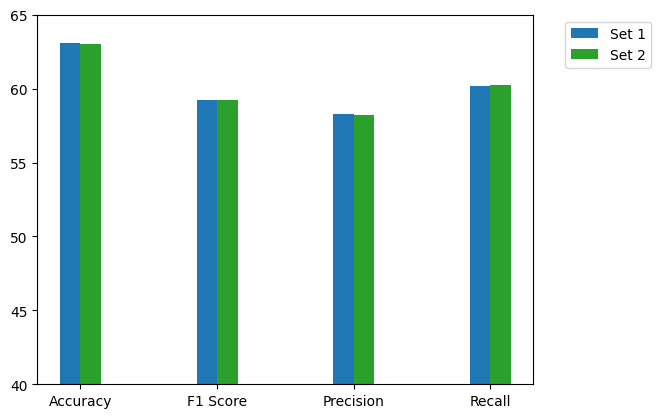

In [ ]:
### Decision tree experiments

## Criterion selection

sets = []

set1 = decision_tree_classifier('gini', 7, [], 1, 1)
set2 = decision_tree_classifier('entropy', 7, [], 1, 1)

sets.append(set1)
sets.append(set2)

plot(sets, 0.15)

## There are no big differences in the metric used for the algorithm, so we will continue with the gini metric.

Accuracy: 62.39 F1 Score: 34.53 Precision: 76.85 Recall: 22.27
Accuracy: 62.4 F1 Score: 34.59 Precision: 76.81 Recall: 22.32
Accuracy: 60.8 F1 Score: 57.4 Precision: 55.63 Recall: 59.28
Accuracy: 60.81 F1 Score: 57.4 Precision: 55.65 Recall: 59.26


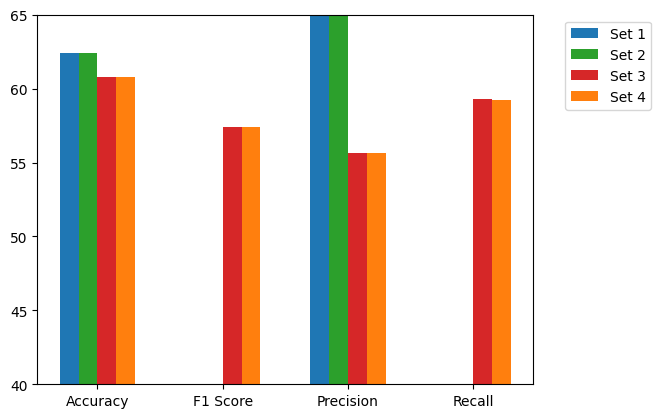

In [ ]:
## Balanced vs imbalanced

sets = []

set1 = decision_tree_classifier('gini', 3, [], 0, 0)
set2 = decision_tree_classifier('gini', 3, [], 0, 1)
set3 = decision_tree_classifier('gini', 3, [], 1, 0)
set4 = decision_tree_classifier('gini', 3, [], 1, 1)

sets.append(set1)
sets.append(set2)
sets.append(set3)
sets.append(set4)

plot(sets, 0.15)

Accuracy: 63.1 F1 Score: 59.24 Precision: 58.31 Recall: 60.2
Accuracy: 63.01 F1 Score: 59.24 Precision: 58.17 Recall: 60.35


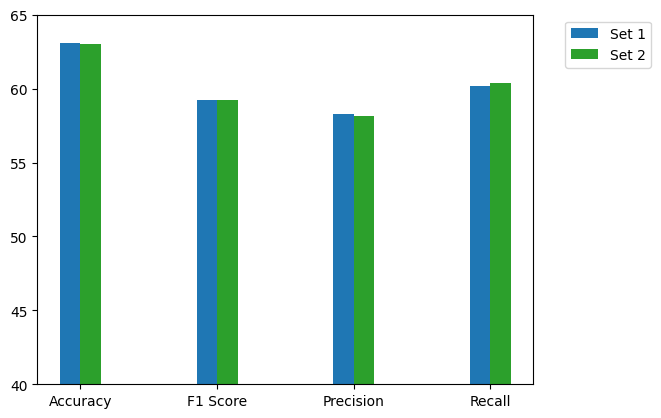

In [ ]:
## Check whether Flight ID influences the classification or not

sets = []

set1 = decision_tree_classifier('gini', 7, [], 1, 0)
set2 = decision_tree_classifier('gini', 7, ['Flight'], 1, 0)

sets.append(set1)
sets.append(set2)

plot(sets, 0.15)

## We notice that (as we also saw in task 1) Flight ID does not influence the prediction of the target variable at all.

Accuracy: 60.4 F1 Score: 51.86 Precision: 56.55 Recall: 47.88
Accuracy: 63.12 F1 Score: 56.0 Precision: 59.75 Recall: 52.7
Accuracy: 63.01 F1 Score: 59.24 Precision: 58.17 Recall: 60.35
Accuracy: 63.86 F1 Score: 59.63 Precision: 59.34 Recall: 59.93
Accuracy: 63.96 F1 Score: 60.01 Precision: 59.33 Recall: 60.69
Accuracy: 63.65 F1 Score: 59.47 Precision: 59.08 Recall: 59.87


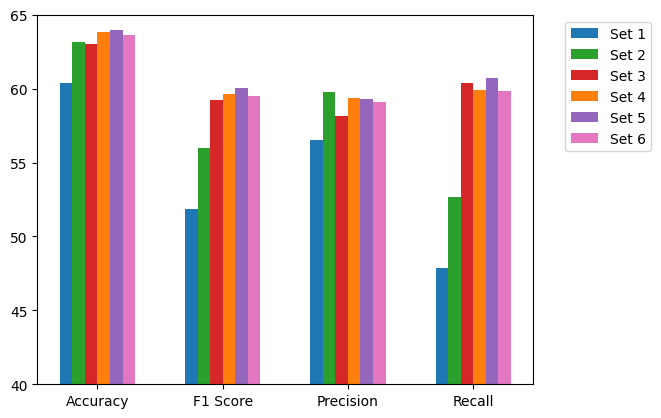

In [ ]:
## We choose the best value of the max_depth parameter

## The max_depth parameter represents the maximum depth a decision tree can reach.
## The higher it is set, the more complex and accurate the tree can be in splitting the data, but it can also be more prone to overfitting.
## Therefore, it is important to find a balance between the maximum depth of the tree and its performance on the data set.

sets = []

set1 = decision_tree_classifier('gini', None, ['Flight'], 1, 1) # 2 is default
set2 = decision_tree_classifier('gini', 5, ['Flight'], 1, 1)
set3 = decision_tree_classifier('gini', 7, ['Flight'], 1, 1)
set4 = decision_tree_classifier('gini', 10, ['Flight'], 1, 1)
set5 = decision_tree_classifier('gini', 13, ['Flight'], 1, 1)
set6 = decision_tree_classifier('gini', 15, ['Flight'], 1, 1)

sets.append(set1)
sets.append(set2)
sets.append(set3)
sets.append(set4)
sets.append(set5)
sets.append(set6)

plot(sets, 0.10)

In [ ]:
### The combination of hyperparameters chosen is:

### decision_tree_classifier('gini', 13, ['Flight'], 1, 1)

## This choice was made following the metrics that must have values as high as possible and at the same time there must be a balance between precision and recall.

## Accuracy : the correct prediction divided by the total number in the matrix
## Precision : how many of the courts that clf marked as positive are really positive
## Recall : how well it identifies positive cases from the total number of positive cases
## F1-score : a measure of precision and recall (detection rate) for a binary classification model,
##            which combines the two measurements to obtain a single value that represents the overall performance of the model

## Filters on certain main components detected in previous tasks

set1 = decision_tree_classifier('gini', 13, ['Flight'], 1, 1)
set1 = decision_tree_classifier('gini', 13, ['Flight', 'Time'], 1, 1)
set1 = decision_tree_classifier('gini', 13, ['Flight', 'Airline'], 1, 1)
set1 = decision_tree_classifier('gini', 13, ['Flight', 'Length'], 1, 1)
set1 = decision_tree_classifier('gini', 13, ['Flight', 'Length', 'Airline', 'AirportFrom', 'AirportTo'], 1, 1)
set1 = decision_tree_classifier('gini', 13, ['Flight', 'DayOfWeek', 'Airline', 'AirportFrom', 'AirportTo'], 1, 1)
set1 = decision_tree_classifier('gini', 13, ['Flight', 'Length', 'Time', 'DayOfWeek'], 1, 1)

Accuracy: 63.96 F1 Score: 60.01 Precision: 59.33 Recall: 60.69
Accuracy: 62.87 F1 Score: 57.4 Precision: 58.7 Recall: 56.15
Accuracy: 60.1 F1 Score: 59.09 Precision: 54.39 Recall: 64.69
Accuracy: 63.91 F1 Score: 59.68 Precision: 59.41 Recall: 59.96
Accuracy: 56.28 F1 Score: 58.28 Precision: 50.69 Recall: 68.55
Accuracy: 58.33 F1 Score: 58.15 Precision: 52.61 Recall: 64.99
Accuracy: 63.22 F1 Score: 57.48 Precision: 59.25 Recall: 55.82


RANDOM FOREST CLASSIFIER

In [ ]:
### Random forest algorithm with hyperparameters tuning

def random_forest_classifier(n_estimators, criterion, max_depth, remove_var, balance, outliers):

  data = airlines
  for var in remove_var :
    data = rmv_var(data, var)

  #data = imbalance_data(data)
  #data = rmv_outliers(data)

  target = data['Class']
  predictors = data.drop(['Class'], axis=1)

  n_folds = 5

  kf = KFold(n_splits=n_folds)

  metrics = []
  conf_matrix = np.zeros((2,2))

  for train_index, test_index in kf.split(predictors):

    x_train, x_test = predictors.iloc[train_index], predictors.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    data_train = pd.concat([x_train, y_train], axis=1);

    if balance == 1:
      data_train = imbalance_data(data_train)
    if outliers == 1:
      data_train = rmv_outliers(data_train)

    x_train = data_train.drop(['Class'], axis=1)
    y_train = data_train['Class']

    clf = RandomForestClassifier(n_estimators = n_estimators, criterion = criterion, max_depth = max_depth, random_state = 42)
    clf.fit(x_train, y_train)

    y_pred = clf.predict(x_test)
    conf_matrix += confusion_matrix(y_test, y_pred)

  print("Confusion matrix:\n\n")
  print(conf_matrix)
  print("\n\n")

  tn = conf_matrix[0,0]
  fp = conf_matrix[0,1]
  fn = conf_matrix[1,0]
  tp = conf_matrix[1,1]

  accuracy = (tp + tn) / (tp + tn + fp + fn)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f1 = 2 * (precision * recall) / (precision + recall)

  metrics.append(round(accuracy * 100, 2))
  metrics.append(round(f1 * 100, 2))
  metrics.append(round(precision * 100, 2))
  metrics.append(round(recall * 100, 2))

  print(f"Accuracy: {round(accuracy * 100, 2)} " + f"F1 Score: {round(f1 * 100, 2)} " + f"Precision: {round(precision * 100, 2)} " + f"Recall: {round(recall * 100, 2)}")
  return metrics

Accuracy: 62.41 F1 Score: 57.78 Precision: 57.81 Recall: 57.74
Accuracy: 64.74 F1 Score: 60.02 Precision: 60.64 Recall: 59.41
Accuracy: 65.22 F1 Score: 60.58 Precision: 61.17 Recall: 60.0
Accuracy: 65.49 F1 Score: 60.78 Precision: 61.54 Recall: 60.05
Accuracy: 65.68 F1 Score: 60.92 Precision: 61.82 Recall: 60.05
Accuracy: 65.77 F1 Score: 60.97 Precision: 61.96 Recall: 60.02


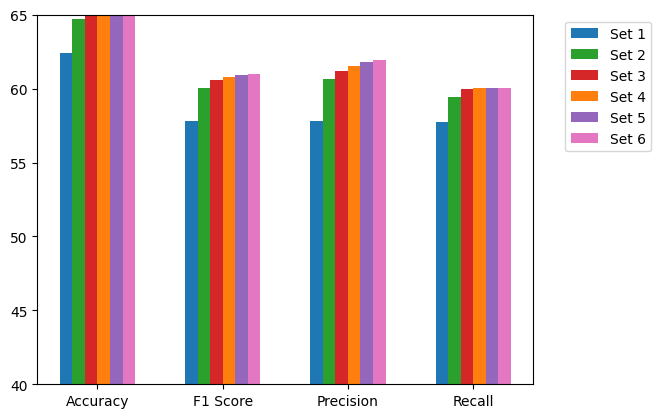

In [ ]:
## Choose an acceptable number of estimators (numbers of decision trees used)

sets = []

set1 = random_forest_classifier(1, 'gini', 13, [], 1, 1)
set2 = random_forest_classifier(5, 'gini', 13, [], 1, 1)
set3 = random_forest_classifier(10, 'gini', 13, [], 1, 1)
set4 = random_forest_classifier(20, 'gini', 13, [], 1, 1)
set5 = random_forest_classifier(50, 'gini', 13, [], 1, 1)
set6 = random_forest_classifier(100, 'gini', 13, [], 1, 1)

sets.append(set1)
sets.append(set2)
sets.append(set3)
sets.append(set4)
sets.append(set5)
sets.append(set6)

plot(sets, 0.10)

## We can see that there are no big differences between 10 and 100 estimators, so for a good classification a very large number
## of estimators would be needed, which would take a lot of time.

Accuracy: 65.68 F1 Score: 60.92 Precision: 61.82 Recall: 60.05
Accuracy: 65.63 F1 Score: 60.89 Precision: 61.75 Recall: 60.06


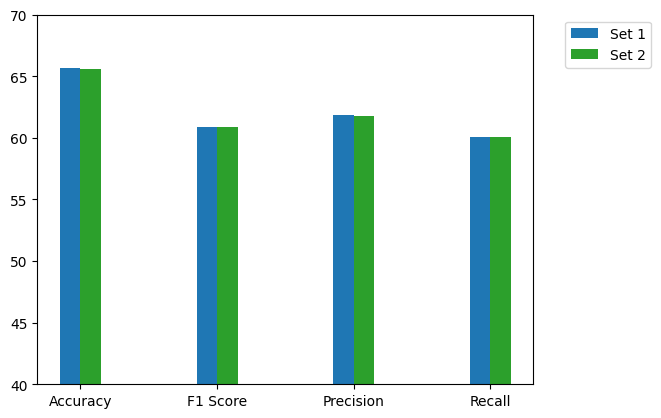

In [ ]:
## We see which metric is better after choosing the number of estimators

sets = []

set1 = random_forest_classifier(50, 'gini', 13, [], 1, 1)
set2 = random_forest_classifier(50, 'entropy', 13, [], 1, 1)

sets.append(set1)
sets.append(set2)

plot(sets, 0.15)

## The chosen metric doesn't matter here either, so we'll use gini further on.

Accuracy: 61.41 F1 Score: 54.9 Precision: 57.27 Recall: 52.72
Accuracy: 62.75 F1 Score: 58.08 Precision: 58.23 Recall: 57.93
Accuracy: 64.79 F1 Score: 59.99 Precision: 60.74 Recall: 59.26
Accuracy: 65.68 F1 Score: 60.92 Precision: 61.82 Recall: 60.05
Accuracy: 65.9 F1 Score: 60.98 Precision: 62.18 Recall: 59.83


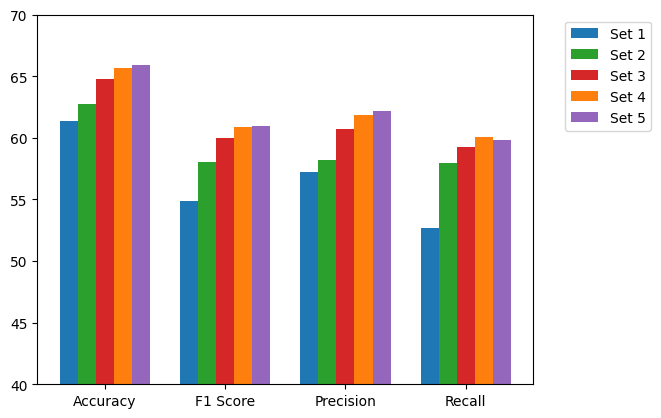

In [ ]:
## We choose the best value of the max_depth parameter

sets = []

set1 = random_forest_classifier(50, 'gini', None, [], 1, 1)
set2 = random_forest_classifier(50, 'gini', 5, [], 1, 1)
set3 = random_forest_classifier(50, 'gini', 10, [], 1, 1)
set4 = random_forest_classifier(50, 'gini', 13, [], 1, 1)
set5 = random_forest_classifier(50, 'gini', 15, [], 1, 1)

sets.append(set1)
sets.append(set2)
sets.append(set3)
sets.append(set4)
sets.append(set5)

plot(sets, 0.15)

Accuracy: 66.15 F1 Score: 54.55 Precision: 67.85 Recall: 45.62
Accuracy: 65.96 F1 Score: 54.2 Precision: 67.63 Recall: 45.22
Accuracy: 65.69 F1 Score: 60.64 Precision: 62.01 Recall: 59.33
Accuracy: 65.59 F1 Score: 60.42 Precision: 61.96 Recall: 58.96


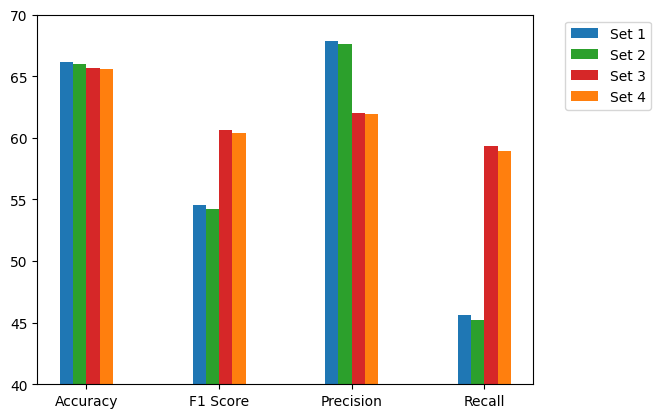

In [ ]:
## Balanced vs imbalanced

sets = []

set1 = random_forest_classifier(50, 'gini', 13, ['Flight'], 0, 0)
set2 = random_forest_classifier(50, 'gini', 13, ['Flight'], 0, 1)
set3 = random_forest_classifier(50, 'gini', 13, ['Flight'], 1, 0)
set4 = random_forest_classifier(50, 'gini', 13, ['Flight'], 1, 1)

sets.append(set1)
sets.append(set2)
sets.append(set3)
sets.append(set4)

plot(sets, 0.10)

In [ ]:
### The combination of hyperparameters chosen is:

### random_forest_classifier(50, 'gini', 13, ['Flight'], 1, 1)

XG BOOST

In [ ]:
### XG Boost algorithm with hyperparameters tuning

def xg_boost_classifier(n_estimators, max_depth, learning_rate, remove_var, balance, outliers):

  data = airlines
  for var in remove_var :
    data = rmv_var(data, var)

  #data = imbalance_data(data)
  #data = rmv_outliers(data)

  target = data['Class']
  predictors = data.drop(['Class'], axis=1)

  n_folds = 5

  kf = KFold(n_splits=n_folds)

  metrics = []
  conf_matrix = np.zeros((2,2))

  for train_index, test_index in kf.split(predictors):

    x_train, x_test = predictors.iloc[train_index], predictors.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    data_train = pd.concat([x_train, y_train], axis=1);

    if balance == 1:
      data_train = imbalance_data(data_train)
    if outliers == 1:
      data_train = rmv_outliers(data_train)

    x_train = data_train.drop(['Class'], axis=1)
    y_train = data_train['Class']

    clf = XGBClassifier(n_estimators = n_estimators, max_depth = max_depth, learning_rate = learning_rate, random_state = 42)
    clf.fit(x_train, y_train)

    y_pred = clf.predict(x_test)
    conf_matrix += confusion_matrix(y_test, y_pred)

  print("Confusion matrix:\n\n")
  print(conf_matrix)
  print("\n\n")

  tn = conf_matrix[0,0]
  fp = conf_matrix[0,1]
  fn = conf_matrix[1,0]
  tp = conf_matrix[1,1]

  accuracy = (tp + tn) / (tp + tn + fp + fn)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f1 = 2 * (precision * recall) / (precision + recall)

  metrics.append(round(accuracy * 100, 2))
  metrics.append(round(f1 * 100, 2))
  metrics.append(round(precision * 100, 2))
  metrics.append(round(recall * 100, 2))

  print(f"Accuracy: {round(accuracy * 100, 2)} " + f"F1 Score: {round(f1 * 100, 2)} " + f"Precision: {round(precision * 100, 2)} " + f"Recall: {round(recall * 100, 2)}")
  return metrics

Accuracy: 63.8 F1 Score: 59.74 Precision: 59.2 Recall: 60.28
Accuracy: 64.84 F1 Score: 60.33 Precision: 60.64 Recall: 60.03
Accuracy: 65.35 F1 Score: 60.72 Precision: 61.33 Recall: 60.12
Accuracy: 65.67 F1 Score: 61.1 Precision: 61.69 Recall: 60.53
Accuracy: 65.94 F1 Score: 61.34 Precision: 62.03 Recall: 60.66
Accuracy: 65.85 F1 Score: 61.11 Precision: 62.01 Recall: 60.24


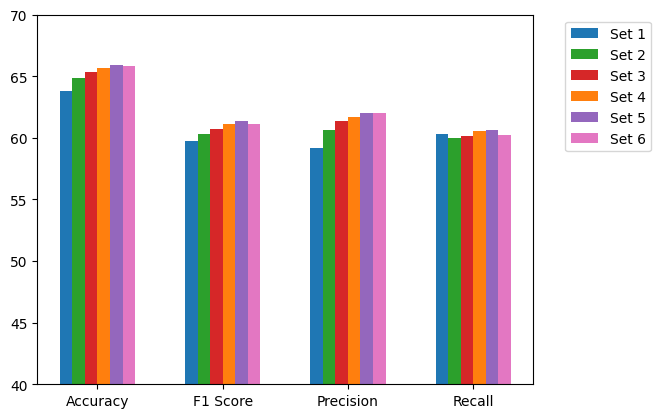

In [ ]:
## Choose an acceptable number of estimators (numbers of decision trees used)

sets = []

set1 = xg_boost_classifier(1, 10, 0.3, ['Flight'], 1, 1)
set2 = xg_boost_classifier(5, 10, 0.3, ['Flight'], 1, 1)
set3 = xg_boost_classifier(10, 10, 0.3, ['Flight'], 1, 1)
set4 = xg_boost_classifier(20, 10, 0.3, ['Flight'], 1, 1)
set5 = xg_boost_classifier(50, 10, 0.3, ['Flight'], 1, 1)
set6 = xg_boost_classifier(100, 10, 0.3, ['Flight'], 1, 1)

sets.append(set1)
sets.append(set2)
sets.append(set3)
sets.append(set4)
sets.append(set5)
sets.append(set6)

plot(sets, 0.10)

Accuracy: 65.36 F1 Score: 60.78 Precision: 61.32 Recall: 60.24
Accuracy: 65.1 F1 Score: 60.47 Precision: 61.02 Recall: 59.93
Accuracy: 65.94 F1 Score: 61.34 Precision: 62.03 Recall: 60.66
Accuracy: 65.25 F1 Score: 60.22 Precision: 61.44 Recall: 59.04
Accuracy: 64.33 F1 Score: 58.77 Precision: 60.57 Recall: 57.08


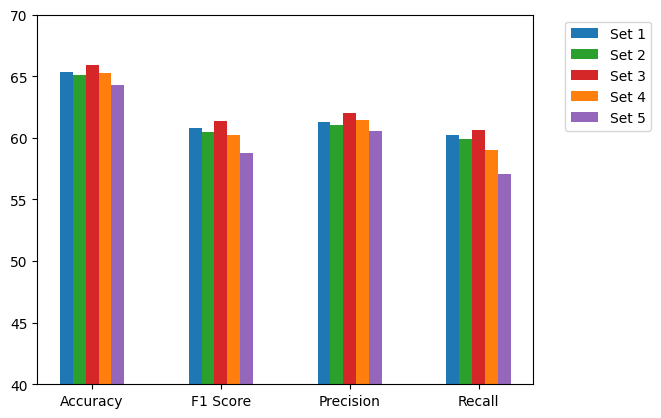

In [ ]:
## We choose the best value of the max_depth parameter

sets = []

set1 = xg_boost_classifier(50, None, 0.3, ['Flight'], 1, 1)
set2 = xg_boost_classifier(50, 5, 0.3, ['Flight'], 1, 1)
set3 = xg_boost_classifier(50, 10, 0.3, ['Flight'], 1, 1)
set4 = xg_boost_classifier(50, 13, 0.3, ['Flight'], 1, 1)
set5 = xg_boost_classifier(50, 15, 0.3, ['Flight'], 1, 1)

sets.append(set1)
sets.append(set2)
sets.append(set3)
sets.append(set4)
sets.append(set5)

plot(sets, 0.10)

Accuracy: 65.56 F1 Score: 60.88 Precision: 61.62 Recall: 60.15
Accuracy: 65.98 F1 Score: 61.25 Precision: 62.16 Recall: 60.37
Accuracy: 65.94 F1 Score: 61.34 Precision: 62.03 Recall: 60.66
Accuracy: 64.67 F1 Score: 60.01 Precision: 60.51 Recall: 59.52


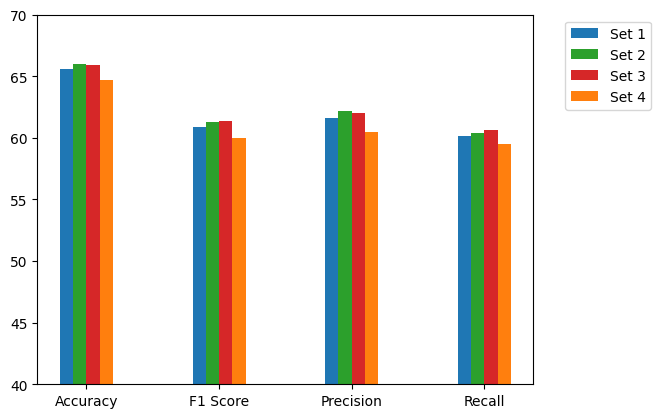

In [ ]:
## We choose the best learning_rate

sets = []

set1 = xg_boost_classifier(50, 10, 0.05, ['Flight'], 1, 1)
set2 = xg_boost_classifier(50, 10, 0.1, ['Flight'], 1, 1)
set3 = xg_boost_classifier(50, 10, 0.3, ['Flight'], 1, 1)
set4 = xg_boost_classifier(50, 10, 0.8, ['Flight'], 1, 1)

sets.append(set1)
sets.append(set2)
sets.append(set3)
sets.append(set4)

plot(sets, 0.10)

In [ ]:
### The combination of hyperparameters chosen is:

### xg_boost_classifier(50, 10, 0.3, ['Flight'], 1, 1)

LOGISTIC REGRESSION

In [ ]:
### Logistic regression algorithm with hyperparameters tuning

def logistic_regression_classifier(solver, multi_class, penalty, max_iter, remove_var, balance, outliers):

  data = airlines
  for var in remove_var :
    data = rmv_var(data, var)

  #data = imbalance_data(data)
  #data = rmv_outliers(data)

  target = data['Class']
  predictors = data.drop(['Class'], axis=1)

  n_folds = 5

  kf = KFold(n_splits=n_folds)

  metrics = []
  conf_matrix = np.zeros((2,2))

  for train_index, test_index in kf.split(predictors):

    x_train, x_test = predictors.iloc[train_index], predictors.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    data_train = pd.concat([x_train, y_train], axis=1);

    if balance == 1:
      data_train = imbalance_data(data_train)
    if outliers == 1:
      data_train = rmv_outliers(data_train)

    x_train = data_train.drop(['Class'], axis=1)
    y_train = data_train['Class']

    clf = LogisticRegression(solver = solver, multi_class = multi_class, penalty = penalty, max_iter = max_iter, random_state = 42)
    clf.fit(x_train, y_train)

    y_pred = clf.predict(x_test)
    conf_matrix += confusion_matrix(y_test, y_pred)

  print("Confusion matrix:\n\n")
  print(conf_matrix)
  print("\n\n")

  tn = conf_matrix[0,0]
  fp = conf_matrix[0,1]
  fn = conf_matrix[1,0]
  tp = conf_matrix[1,1]

  accuracy = (tp + tn) / (tp + tn + fp + fn)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f1 = 2 * (precision * recall) / (precision + recall)

  metrics.append(round(accuracy * 100, 2))
  metrics.append(round(f1 * 100, 2))
  metrics.append(round(precision * 100, 2))
  metrics.append(round(recall * 100, 2))

  print(f"Accuracy: {round(accuracy * 100, 2)} " + f"F1 Score: {round(f1 * 100, 2)} " + f"Precision: {round(precision * 100, 2)} " + f"Recall: {round(recall * 100, 2)}")
  return metrics

Accuracy: 57.66 F1 Score: 54.96 Precision: 52.22 Recall: 58.0


/usr/local/lib/python3.9/dist-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/usr/local/lib/python3.9/dist-packages/scipy/optimize/_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/usr/local/lib/python3.9/dist-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/usr/local/lib/python3.9/dist-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did n

Accuracy: 57.65 F1 Score: 54.94 Precision: 52.22 Recall: 57.96
Accuracy: 57.65 F1 Score: 54.94 Precision: 52.22 Recall: 57.96
Accuracy: 57.65 F1 Score: 54.96 Precision: 52.22 Recall: 58.0


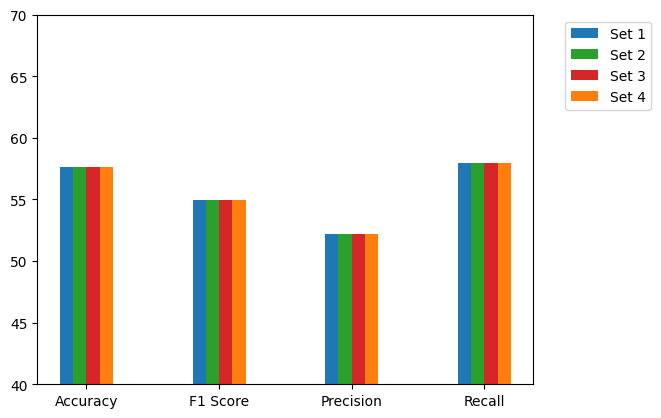

In [ ]:
## We try different algorithms to optimize the cost function

sets = []

set1 = logistic_regression_classifier('liblinear', 'auto', None, 1000, ['Flight'], 1, 1)
set2 = logistic_regression_classifier('newton-cg', 'auto', None, 1000, ['Flight'], 1, 1)
set3 = logistic_regression_classifier('lbfgs', 'auto', None, 1000, ['Flight'], 1, 1)
set4 = logistic_regression_classifier('sag', 'auto', None, 1000, ['Flight'], 1, 1)

sets.append(set1)
sets.append(set2)
sets.append(set3)
sets.append(set4)

plot(sets, 0.10)


In [ ]:
## We try different penaltys used for the cost function

set1 = logistic_regression_classifier('liblinear', 'auto', 'none', 1000, ['Flight'], 1, 1)
set2 = logistic_regression_classifier('liblinear', 'auto', 'l1', 1000, ['Flight'], 1, 1)
set3 = logistic_regression_classifier('liblinear', 'auto', 'l2', 1000, ['Flight'], 1, 1)
set4 = logistic_regression_classifier('liblinear', 'auto', 'elasticnet', 1000, ['Flight'], 1, 1)

set5 = logistic_regression_classifier('lbfgs', 'auto', 'l2', 1000, ['Flight'], 1, 1)

Accuracy: 57.66 F1 Score: 54.96 Precision: 52.22 Recall: 58.0
Accuracy: 57.66 F1 Score: 54.96 Precision: 52.22 Recall: 58.0
Accuracy: 57.66 F1 Score: 54.96 Precision: 52.22 Recall: 58.0
Accuracy: 57.66 F1 Score: 54.96 Precision: 52.22 Recall: 58.0
Accuracy: 57.65 F1 Score: 54.94 Precision: 52.22 Recall: 57.96


In [ ]:
## We try different multi_class parameters to specify how to approach the classification problem

set1 = logistic_regression_classifier('liblinear', 'auto', 'none', 1000, ['Flight'], 1, 1)
set2 = logistic_regression_classifier('liblinear', 'ovr', 'none', 1000, ['Flight'], 1, 1)

set3 = logistic_regression_classifier('lbfgs', 'ovr', 'l2', 1000, ['Flight'], 1, 1)

Accuracy: 57.66 F1 Score: 54.96 Precision: 52.22 Recall: 58.0
Accuracy: 57.66 F1 Score: 54.96 Precision: 52.22 Recall: 58.0
Accuracy: 57.65 F1 Score: 54.94 Precision: 52.22 Recall: 57.96


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 52.16 F1 Score: 56.49 Precision: 47.48 Recall: 69.71
Accuracy: 57.66 F1 Score: 54.96 Precision: 52.22 Recall: 58.0
Accuracy: 57.66 F1 Score: 54.96 Precision: 52.22 Recall: 58.0
Accuracy: 57.66 F1 Score: 54.96 Precision: 52.22 Recall: 58.0
Accuracy: 57.66 F1 Score: 54.96 Precision: 52.22 Recall: 58.0


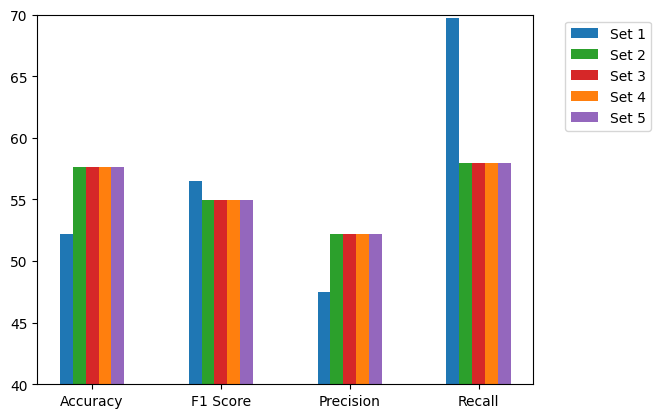

In [ ]:
## We try different number of iterations

sets = []

set1 = logistic_regression_classifier('liblinear', 'auto', 'none', 1, ['Flight'], 1, 1)
set2 = logistic_regression_classifier('liblinear', 'auto', 'none', 50, ['Flight'], 1, 1)
set3 = logistic_regression_classifier('liblinear', 'auto', 'none', 300, ['Flight'], 1, 1)
set4 = logistic_regression_classifier('liblinear', 'auto', 'none', 1000, ['Flight'], 1, 1)
set5 = logistic_regression_classifier('liblinear', 'auto', 'none', 5000, ['Flight'], 1, 1)

sets.append(set1)
sets.append(set2)
sets.append(set3)
sets.append(set4)
sets.append(set5)

plot(sets, 0.10)

## If the solution does not converge in the specified number of iterations, the solver will be stopped and the last solution will be returned.

In [ ]:
### The combination of hyperparameters chosen is:

### logistic_regression_classifier('liblinear', 'auto', 'none', 300, ['Flight'], 1, 1)

NAIVE BAYES

In [ ]:
### Bayes naive algorithm

def bayes_naive_classifier(remove_var, balance, outliers):

  data = airlines
  for var in remove_var :
    data = rmv_var(data, var)

  #data = imbalance_data(data)
  #data = rmv_outliers(data)

  target = data['Class']
  predictors = data.drop(['Class'], axis=1)

  n_folds = 5

  kf = KFold(n_splits=n_folds)

  metrics = []
  conf_matrix = np.zeros((2,2))

  for train_index, test_index in kf.split(predictors):

    x_train, x_test = predictors.iloc[train_index], predictors.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    data_train = pd.concat([x_train, y_train], axis=1);

    if balance == 1:
      data_train = imbalance_data(data_train)
    if outliers == 1:
      data_train = rmv_outliers(data_train)

    x_train = data_train.drop(['Class'], axis=1)
    y_train = data_train['Class']

    clf = GaussianNB()
    clf.fit(x_train, y_train)

    y_pred = clf.predict(x_test)
    conf_matrix += confusion_matrix(y_test, y_pred)

  print("Confusion matrix:\n\n")
  print(conf_matrix)
  print("\n\n")

  tn = conf_matrix[0,0]
  fp = conf_matrix[0,1]
  fn = conf_matrix[1,0]
  tp = conf_matrix[1,1]

  accuracy = (tp + tn) / (tp + tn + fp + fn)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f1 = 2 * (precision * recall) / (precision + recall)

  metrics.append(round(accuracy * 100, 2))
  metrics.append(round(f1 * 100, 2))
  metrics.append(round(precision * 100, 2))
  metrics.append(round(recall * 100, 2))

  print(f"Accuracy: {round(accuracy * 100, 2)} " + f"F1 Score: {round(f1 * 100, 2)} " + f"Precision: {round(precision * 100, 2)} " + f"Recall: {round(recall * 100, 2)}")
  return metrics

In [ ]:
## We have a parameter priors with prior probabilities of the classes

set1 = bayes_naive_classifier(['Flight'], 0, 0)
set2 = bayes_naive_classifier(['Flight'], 0, 1)
set3 = bayes_naive_classifier(['Flight'], 1, 0)
set4 = bayes_naive_classifier(['Flight'], 1, 1)

Accuracy: 58.25 F1 Score: 43.72 Precision: 54.72 Recall: 36.41
Accuracy: 58.23 F1 Score: 44.9 Precision: 54.44 Recall: 38.21
Accuracy: 57.6 F1 Score: 55.9 Precision: 52.07 Recall: 60.34
Accuracy: 57.58 F1 Score: 56.21 Precision: 52.03 Recall: 61.11


In [ ]:
### The combination of hyperparameters chosen is:

### bayes_naive_classifier(['Flight'], 1, 1)

K-NN

In [ ]:
### K-NN algorithm with hyperparameters tuning

def k_nn_classifier(n_neighbors, metric, remove_var, balance, outliers):

  data = airlines
  for var in remove_var :
    data = rmv_var(data, var)

  #data = imbalance_data(data)
  #data = rmv_outliers(data)

  target = data['Class']
  predictors = data.drop(['Class'], axis=1)

  n_folds = 5

  kf = KFold(n_splits=n_folds)

  metrics = []
  conf_matrix = np.zeros((2,2))

  for train_index, test_index in kf.split(predictors):

    x_train, x_test = predictors.iloc[train_index], predictors.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    data_train = pd.concat([x_train, y_train], axis=1);

    if balance == 1:
      data_train = imbalance_data(data_train)
    if outliers == 1:
      data_train = rmv_outliers(data_train)

    x_train = data_train.drop(['Class'], axis=1)
    y_train = data_train['Class']

    clf = KNeighborsClassifier(n_neighbors = n_neighbors, metric = metric)
    clf.fit(x_train, y_train)

    y_pred = clf.predict(x_test)
    conf_matrix += confusion_matrix(y_test, y_pred)

  print("Confusion matrix:\n\n")
  print(conf_matrix)
  print("\n\n")

  tn = conf_matrix[0,0]
  fp = conf_matrix[0,1]
  fn = conf_matrix[1,0]
  tp = conf_matrix[1,1]

  accuracy = (tp + tn) / (tp + tn + fp + fn)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f1 = 2 * (precision * recall) / (precision + recall)

  metrics.append(round(accuracy * 100, 2))
  metrics.append(round(f1 * 100, 2))
  metrics.append(round(precision * 100, 2))
  metrics.append(round(recall * 100, 2))

  print(f"Accuracy: {round(accuracy * 100, 2)} " + f"F1 Score: {round(f1 * 100, 2)} " + f"Precision: {round(precision * 100, 2)} " + f"Recall: {round(recall * 100, 2)}")
  return metrics

In [ ]:
set1 = k_nn_classifier(20, 'minkowski', ['Flight'], 1, 1)

Accuracy: 63.69 F1 Score: 58.29 Precision: 59.69 Recall: 56.96


NEURAL NETWORKS

In [ ]:
### ANN algorithm with hyperparameters tuning

def ann_classifier(layers_activation, last_layer_activation, optimizer, loss, remove_var, balance, outliers):

  data = airlines
  for var in remove_var :
    data = rmv_var(data, var)

  #data = imbalance_data(data)
  #data = rmv_outliers(data)

  target = data['Class']
  predictors = data.drop(['Class'], axis=1)

  n_folds = 5

  kf = KFold(n_splits=n_folds)

  metr = []
  conf_matrix = np.zeros((2,2))

  for train_index, test_index in kf.split(predictors):

    x_train, x_test = predictors.iloc[train_index], predictors.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    data_train = pd.concat([x_train, y_train], axis=1);

    if balance == 1:
      data_train = imbalance_data(data_train)
    if outliers == 1:
      data_train = rmv_outliers(data_train)

    x_train = data_train.drop(['Class'], axis=1)
    y_train = data_train['Class']

    clf = keras.models.Sequential()
    clf.add(Dense(units=305, activation=layers_activation))
    clf.add(Dropout(0.1))
    clf.add(Dense(units=153, activation=layers_activation))
    clf.add(Dropout(0.1))
    clf.add(Dense(units=1, activation=last_layer_activation));


    clf.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])
    clf.fit(x_train, y_train, batch_size = 32, epochs = 15)

    y_pred = clf.predict(x_test)
    y_pred = (y_pred > 0.5) ## threshold

    conf_matrix += confusion_matrix(y_test, y_pred)

  print("Confusion matrix:\n\n")
  print(conf_matrix)
  print("\n\n")

  tn = conf_matrix[0,0]
  fp = conf_matrix[0,1]
  fn = conf_matrix[1,0]
  tp = conf_matrix[1,1]

  accuracy = (tp + tn) / (tp + tn + fp + fn)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f1 = 2 * (precision * recall) / (precision + recall)

  metr.append(round(accuracy * 100, 2))
  metr.append(round(f1 * 100, 2))
  metr.append(round(precision * 100, 2))
  metr.append(round(recall * 100, 2))

  print(f"Accuracy: {round(accuracy * 100, 2)} " + f"F1 Score: {round(f1 * 100, 2)} " + f"Precision: {round(precision * 100, 2)} " + f"Recall: {round(recall * 100, 2)}")
  return metr

In [ ]:
## After many tests with types of activation functions (sigmoid, relu and LeakyRelu) and optimization functions (sgd or adam) I chose the option:

set1 = ann_classifier('LeakyReLU', 'sigmoid', 'adam', 'binary_crossentropy', ['Flight'], 1, 1);

SVM

In [ ]:
### SVM algorithm

def svm_classifier(kernel, gamma, remove_var, balance, outliers):

  data = airlines
  for var in remove_var :
    data = rmv_var(data, var)

  #data = imbalance_data(data)
  #data = rmv_outliers(data)

  target = data['Class']
  predictors = data.drop(['Class'], axis=1)

  n_folds = 5

  kf = KFold(n_splits=n_folds)

  metrics = []
  conf_matrix = np.zeros((2,2))

  for train_index, test_index in kf.split(predictors):

    x_train, x_test = predictors.iloc[train_index], predictors.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    data_train = pd.concat([x_train, y_train], axis=1);

    if balance == 1:
      data_train = imbalance_data(data_train)
    if outliers == 1:
      data_train = rmv_outliers(data_train)

    x_train = data_train.drop(['Class'], axis=1)
    y_train = data_train['Class']

    clf = svm.SVC(kernel = kernel, gamma = gamma, random_state = 42)
    clf.fit(x_train, y_train)

    y_pred = clf.predict(x_test)
    conf_matrix += confusion_matrix(y_test, y_pred)

  tn = conf_matrix[0,0]
  fp = conf_matrix[0,1]
  fn = conf_matrix[1,0]
  tp = conf_matrix[1,1]

  print("Confusion matrix:\n\n")
  print(conf_matrix)
  print("\n\n")

  accuracy = (tp + tn) / (tp + tn + fp + fn)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f1 = 2 * (precision * recall) / (precision + recall)

  metrics.append(round(accuracy * 100, 2))
  metrics.append(round(f1 * 100, 2))
  metrics.append(round(precision * 100, 2))
  metrics.append(round(recall * 100, 2))

  print(f"Accuracy: {round(accuracy * 100, 2)} " + f"F1 Score: {round(f1 * 100, 2)} " + f"Precision: {round(precision * 100, 2)} " + f"Recall: {round(recall * 100, 2)}")
  return metrics

In [ ]:
### Choose the best model for us

set2 = svm_classifier('linear', 'scale', ['Flight'], 1, 1)


# See best models for all algorithms

Decision tree classifier: 


Confusion matrix:


[[199173.  99945.]
 [ 94439. 145825.]]



Accuracy: 63.96 F1 Score: 60.01 Precision: 59.33 Recall: 60.69



Random forest classifier: 


Confusion matrix:


[[212132.  86986.]
 [ 98597. 141667.]]



Accuracy: 65.59 F1 Score: 60.42 Precision: 61.96 Recall: 58.96



XG boost classifier: 


Confusion matrix:


[[209899.  89219.]
 [ 94516. 145748.]]



Accuracy: 65.94 F1 Score: 61.34 Precision: 62.03 Recall: 60.66



Logistic regression classifier: 


Confusion matrix:


[[171623. 127495.]
 [100906. 139358.]]



Accuracy: 57.66 F1 Score: 54.96 Precision: 52.22 Recall: 58.0



Naive bayes classifier: 


Confusion matrix:


[[163742. 135376.]
 [ 93432. 146832.]]



Accuracy: 57.58 F1 Score: 56.21 Precision: 52.03 Recall: 61.11



K-NN classifier: 


Confusion matrix:


[[206675.  92443.]
 [103405. 136859.]]



Accuracy: 63.69 F1 Score: 58.29 Precision: 59.69 Recall: 56.96





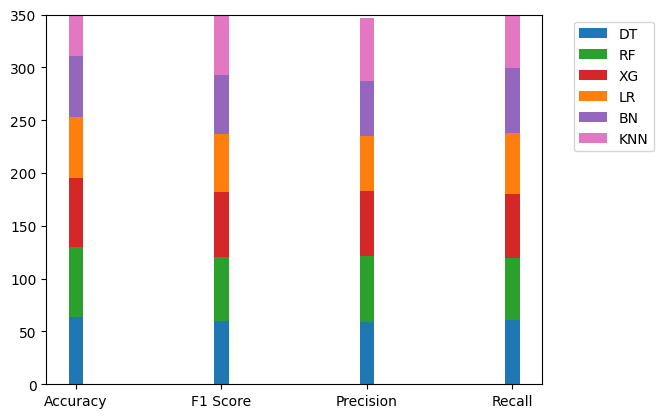

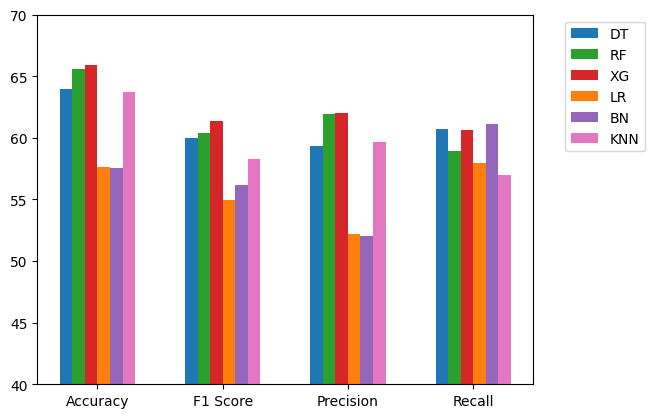

Epoch 1/15
14686/14686 [==============================] - 61s 4ms/step - loss: 0.8569 - accuracy: 0.5443
Epoch 2/15
14686/14686 [==============================] - 58s 4ms/step - loss: 0.6841 - accuracy: 0.5608
Epoch 3/15
14686/14686 [==============================] - 62s 4ms/step - loss: 0.6830 - accuracy: 0.5635
Epoch 4/15
14686/14686 [==============================] - 59s 4ms/step - loss: 0.6825 - accuracy: 0.5645
Epoch 5/15
14686/14686 [==============================] - 59s 4ms/step - loss: 0.6823 - accuracy: 0.5641
Epoch 6/15
14686/14686 [==============================] - 61s 4ms/step - loss: 0.6821 - accuracy: 0.5645
Epoch 7/15
14686/14686 [==============================] - 57s 4ms/step - loss: 0.6816 - accuracy: 0.5655
Epoch 8/15
14686/14686 [==============================] - 57s 4ms/step - loss: 0.6816 - accuracy: 0.5663
Epoch 9/15
14686/14686 [==============================] - 53s 4ms/step - loss: 0.6810 - accuracy: 0.5682
Epoch 10/15
14686/14686 [==============================

In [ ]:
print("Decision tree classifier: \n\n")
dt = decision_tree_classifier('gini', 13, ['Flight'], 1, 1)
print("\n\n")

print("Random forest classifier: \n\n")
rf = random_forest_classifier(50, 'gini', 13, ['Flight'], 1, 1)
print("\n\n")

print("XG boost classifier: \n\n")
xg = xg_boost_classifier(50, 10, 0.3, ['Flight'], 1, 1)
print("\n\n")

print("Logistic regression classifier: \n\n")
lr = logistic_regression_classifier('liblinear', 'auto', 'l2', 300, ['Flight'], 1, 1)
print("\n\n")

print("Naive bayes classifier: \n\n")
bn = bayes_naive_classifier(['Flight'], 1, 1)
print("\n\n")

print("K-NN classifier: \n\n")
knn = k_nn_classifier(20, 'minkowski', ['Flight'], 1, 1)
print("\n\n")

sets = []
sets.append(dt)
sets.append(rf)
sets.append(xg)
sets.append(lr)
sets.append(bn)
sets.append(knn)

colors = ['tab:blue', 'tab:green', 'tab:red', 'tab:orange', 'tab:purple', 'tab:pink', 'tab:black', 'tab:yellow']
labels = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
methods = ['DT', 'RF', 'XG', 'LR', 'BN', 'KNN']

num_sets = len(sets)
fig, ax = plt.subplots()

bottoms = np.zeros(len(labels)) # inițializăm poziția de jos a fiecărei bare cu 0

for i in range(num_sets):
    x = np.arange(len(labels))
    ax.bar(x, sets[i], 0.10, bottom=bottoms, color=colors[i], label=methods[i])
    bottoms += sets[i] # actualizăm poziția de jos a fiecărei bare cu valoarea curentă a setului

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim([0, 350])
ax.set_xticks(x)
ax.set_xticklabels(labels)

plt.show()

plot(sets, 0.10)

set1 = ann_classifier('LeakyReLU', 'sigmoid', 'adam', 'binary_crossentropy', ['Flight'], 1, 1);
set2 = svm_classifier('linear', 'scale', ['Flight'], 1, 1)